<a href="https://colab.research.google.com/github/AnuvabSen1/Speech_Command_Classification_using_Differential_Algorithm/blob/main/GA_MFCC_Speech_Features_Codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pathlib
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D,MaxPooling2D,Flatten,LSTM,BatchNormalization,GlobalAveragePooling2D
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.applications.resnet import ResNet50
from keras.utils.np_utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint
 
import librosa as lr

Commands: ['yes' 'down' 'right' 'left' 'no' 'stop' 'up' 'go']
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/go/ac652c60_nohash_0.wav', shape=(), dtype=string)
Training set size 6400
Validation set size 1000
Test set size 600
label
Tensor("strided_slice:0", shape=(), dtype=string)
waveform
Tensor("Squeeze:0", shape=(None,), dtype=float32)


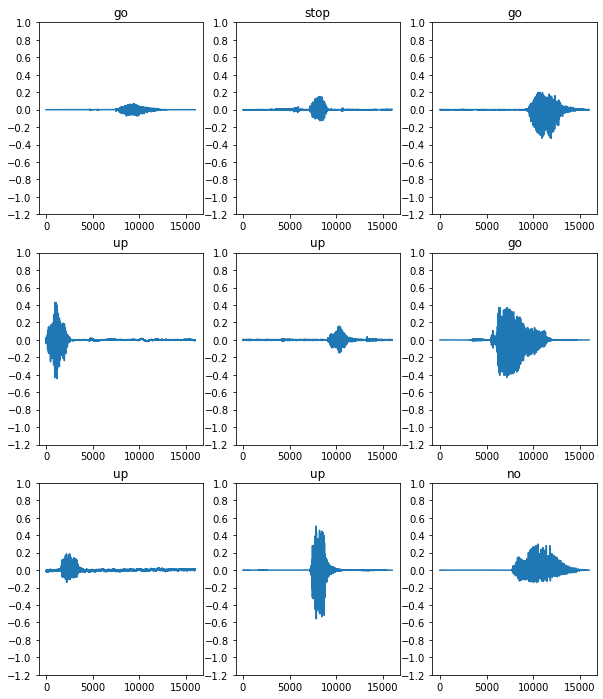

In [ ]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
 
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)
 
 
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])
 
 
 
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 1000]
test_files = filenames[-600:]
 
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))


def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)
 
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
 
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]  
 
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  print("label")
  print(label)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  print("waveform")
  print(waveform)
  return waveform, label
 
 
 
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)
 
plt.show()




In [ ]:
import numpy as np
import librosa
import librosa.display
from IPython.lib.display import Audio
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable


import seaborn as sns


#taking signal and sampling range

file = 'http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip'
ipd.Audio(file)

y, sr = librosa.load(file)
y.shape  
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: ignored

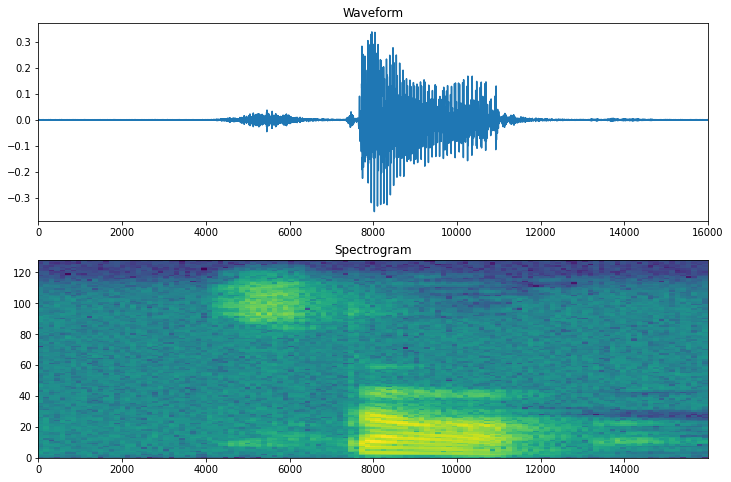

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)
 
 
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


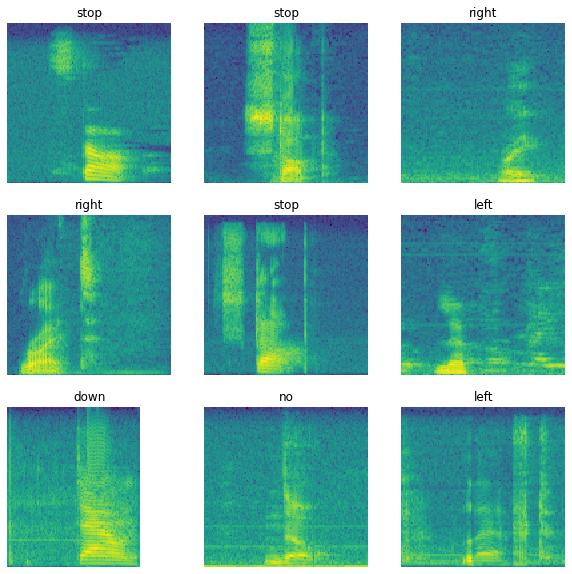

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id
 
 
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
 
 
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds
 
 
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
print("test_ds")
print(type(train_ds)) 
 
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size) 
 
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

In [ ]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D,MaxPooling2D,Flatten,LSTM,BatchNormalization,GlobalAveragePooling2D
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint

import librosa as lr

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

In [ ]:
from keras import layers
from keras import models  
from keras.callbacks import EarlyStopping

In [ ]:
def CNN_model( f1, f2, f3, f4, k, a1, a2, d1, d2, op, ep):
  model = models.Sequential([  
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
  ])

  model.add(Conv2D(input_shape=(32,32, 1),filters=f1,kernel_size=(k,k),padding="same", activation=a1))
  model.add(Conv2D(filters=f1,kernel_size=(k,k),padding="same", activation=a1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))
  model.add(Dropout(d1))

  model.add(Conv2D(filters=f2, kernel_size=(k,k), padding="same", activation=a2))
  model.add(Conv2D(filters=f2, kernel_size=(k,k), padding="same", activation=a2))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))
  model.add(Dropout(d2))

  model.add(Conv2D(filters=f3, kernel_size=(k,k), padding="same", activation=a2))
  model.add(Conv2D(filters=f3, kernel_size=(k,k), padding="same", activation=a2))
  model.add(Conv2D(filters=f3, kernel_size=(k,k), padding="same", activation=a2))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))
  model.add(Dropout(d2))

  model.add(Conv2D(filters=f2, kernel_size=(k,k), padding="same", activation=a1))
  model.add(Conv2D(filters=f2, kernel_size=(k,k), padding="same", activation=a1))
  model.add(Conv2D(filters=f2, kernel_size=(k,k), padding="same", activation=a1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))
  model.add(Dropout(d1))


  model.add(Conv2D(filters=f3, kernel_size=(k,k), padding="same", activation=a1))
  model.add(Conv2D(filters=f3, kernel_size=(k,k), padding="same", activation=a1))
  model.add(Conv2D(filters=f3, kernel_size=(k,k), padding="same", activation=a1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))
  model.add(Dropout(d1))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=f4,activation=a1))
  model.add(BatchNormalization())
  model.add(Dense(units=f4,activation=a1))
  model.add(Dense(units=num_labels, activation="softmax"))

  model.compile(
    optimizer=op,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
  )
  EPOCHS = ep
  history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
  )
  #store history values in global dic.
  return model

In [ ]:
from random import choice
from random import uniform
from numpy.random import randint

In [ ]:
def initialization():  
  parameters = {}  
  f1 = choice([16, 32, 64])
  parameters["f1"] = f1
  f2 = choice([32, 64, 128])
  parameters["f2"] = f2
  f3 = choice([32, 64, 128])
  parameters["f3"] = f3
  f4 = choice([128, 256, 512])
  parameters["f4"] = f4
  k = choice([3,5])
  parameters["k"] = k
  a1 = choice(["relu", "selu", "elu"])
  parameters["a1"] = a1
  a2 = choice(["relu", "selu", "elu"])
  parameters["a2"] = a2
  d1 = round(uniform(0.1, 0.5), 1)
  parameters["d1"] = d1
  d2 = round(uniform(0.1, 0.5), 1)
  parameters["d2"] = d2
  op = choice(["adamax", "adadelta", "adam", "adagrad"])
  parameters["op"] = op
  ep = randint(50,100)
  parameters["ep"] = ep  
  return parameters

In [ ]:
def generate_population(n):
  population = []
  for i in range(n):
    chromosome = initialization()
    population.append(chromosome)
  return population

In [ ]:
# Fitness evaluation metric: Classification Accuracy 
def fitness_evaluation(model):
  metrics = model.evaluate(test_ds)
  print(f"metrics:{metrics}")
  return metrics[1]

In [ ]:
# Roulette wheel selection method
def selection(population_fitness):
  total = sum(population_fitness)
  percentage = [round((x/total) * 100) for x in population_fitness]
  selection_wheel = []
  for pop_index,num in enumerate(percentage):
    selection_wheel.extend([pop_index]*num)
  parent1_ind = choice(selection_wheel)
  parent2_ind = choice(selection_wheel)
  return [parent1_ind, parent2_ind]

In [ ]:
def crossover(parent1, parent2):
  child1 = {}  
  child2 = {}

  child1["f1"] = choice([parent1["f1"], parent2["f1"]])
  child1["f2"] = choice([parent1["f2"], parent2["f2"]])
  child1["f3"] = choice([parent1["f3"], parent2["f3"]])
  child1["f4"] = choice([parent1["f4"], parent2["f4"]])

  child2["f1"] = choice([parent1["f1"], parent2["f1"]])
  child2["f2"] = choice([parent1["f2"], parent2["f2"]])
  child2["f3"] = choice([parent1["f3"], parent2["f3"]])
  child2["f4"] = choice([parent1["f4"], parent2["f4"]])

  child1["k"] = choice([parent1["k"], parent2["k"]])
  child2["k"] = choice([parent1["k"], parent2["k"]])

  child1["a1"] = parent1["a2"]
  child2["a1"] = parent2["a2"]

  child1["a2"] = parent2["a1"]
  child2["a2"] = parent1["a1"]

  child1["d1"] = parent1["d1"]
  child2["d1"] = parent2["d1"]

  child1["d2"] = parent2["d2"]
  child2["d2"] = parent1["d2"]

  child1["op"] = parent2["op"]
  child2["op"] = parent1["op"]

  child1["ep"] = parent1["ep"]
  child2["ep"] = parent2["ep"]  
  return [child1, child2]

In [ ]:
def mutation(chromosome):
  flag = randint(0,40)
  if flag <= 20:
    chromosome["ep"] += randint(0, 10)  
  return chromosome

In [ ]:
generations = 12
threshold = 90
num_pop = 10

population = generate_population(num_pop)
acc_best = []
par_total = []
acc_total = []
par_best = []
for generation in range(generations):

  population_fitness = []
  per1=[]
  for chromosome in population:
    f1 = chromosome["f1"]
    f2 = chromosome["f2"]
    f3 = chromosome["f3"]
    f4 = chromosome["f4"]
    k = chromosome["k"]
    a1 = chromosome["a1"]
    a2 = chromosome["a2"]
    d1 = chromosome["d1"]
    d2 = chromosome["d2"]
    op = chromosome["op"]
    ep = chromosome["ep"]

    try:
      model = CNN_model(f1, f2, f3, f4, k, a1, a2, d1, d2, op, ep)
      acc = fitness_evaluation(model)
      par_total.append(chromosome)
      acc_total.append(acc)
      per1.append(chromosome)
      print("Parameters: ", chromosome)
      print("Accuracy: ", round(acc,3))
    except:
      acc=0
      print("Parameters: ", chromosome)
      print("Invalid parameters - Build fail")

    population_fitness.append(acc)
  print(population_fitness)
  parents_ind = selection(population_fitness)
  parent1 = population[parents_ind[0]]
  parent2 = population[parents_ind[1]]

  children = crossover(parent1, parent2)
  child1 = mutation(children[0])
  child2 = mutation(children[1])

  population.append(child1)
  population.append(child2)

  print("Generation ", generation+1," Outcome: ")
  if max(population_fitness) >= threshold:
    print("Obtained desired accuracy: ", max(population_fitness))
    break
  else:
    print("Maximum accuracy in generation {} : {}".format(generation+1, max(population_fitness)))
    max_pop = max(population_fitness)
    c1=population_fitness.index(max_pop)
    par_best.append(per1[c1])
    acc_best.append(max_pop)

  first_min = min(population_fitness)
  first_min_ind = population_fitness.index(first_min)
  population.remove(population[first_min_ind])
  second_min = min(population_fitness)
  second_min_ind = population_fitness.index(second_min)
  population.remove(population[second_min_ind])

print(par_total)
print(acc_total)
print(par_best)  
print(acc_best)

In [ ]:
var1=len(acc_best)
acc_best.sort()  
print(acc_best[var1-1])